<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./2_2b_OLCI_ope_rep_time_series.ipynb" target="_blank"><< OLCI data access: Acquiring a time series across operational and reprocessing collections</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./2_3b_OLCI_SNAP_batch_processing_C2RCC.ipynb" target="_blank">OLCI SNAP processing: IdePiX and C2RCC >></a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Ben Loveday (EUMETSAT/Innoflair UG), Hayley Evers-King (EUMETSAT), Ana Ruescas (Brockmann Consult GmbH / University of Valencia)

<html>
    <div style="float:left"><a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/sensors/learn-olci"><img src="https://img.shields.io/badge/open-EUMETLAB-E67E22.svg?style=flat&logo=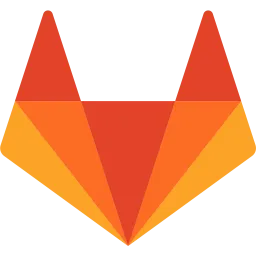" alt="Open in EUMETLAB"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
  <div style="width:100%">
    <div style="float:left"><a href="https://user.eumetsat.int/search-view?term=learn%20olci&sort=score%20desc&facets=%7B%22contentTypes%22:%5B%22Resources%7CSoftware%20%26%20code%22%5D,%22org-satellite-sensor%22:%5B%22EUMETSAT%7CSentinel-3%7COLCI%22%5D,%22theme%22:%5B%22Marine%22,%22Marine%7CMaritime%20safety%22,%22Marine%7COcean%20biogeochemistry%22,%22Marine%7COcean%20dynamics%22,%22Marine%7CWater%20quality%22%5D%7D"><img src="https://img.shields.io/badge/open-USER PORTAL-154360.svg?style=flat&logo=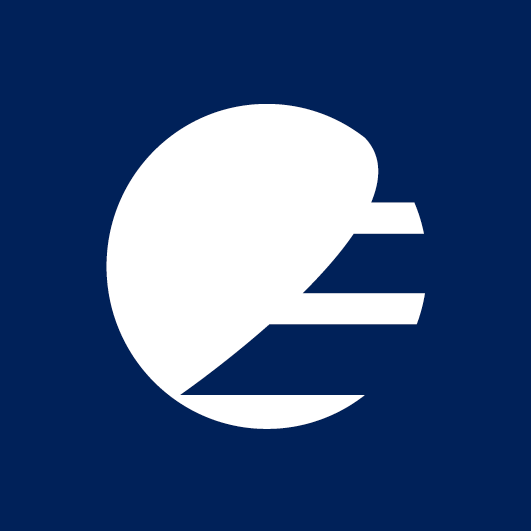" alt="Open in user portal"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OLCI: Advanced</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
        
This notebook has the following pre-requisites:

- **<a href="../2_OLCI_advanced/2_2a_acquire_OLCI_time_series.ipynb">2_2a_acquire_OLCI_time_series.ipynb</a>** will download the example data you need to run this notebook. You **must** make sure you complete the challenge at the end to get the Level-2 products.
- You will also need to install the latest version (currently v10) of the **<a href="https://step.esa.int/main/download/snap-download/" target="_blank">ESA SNAP package</a>**, which provides the Graph Processing Tool (GPT)
</div>
<hr>

# 2.3a OLCI batch-processing with SNAP: subsetting, flagging and reprojection

### Data used

| Dataset | EUMETSAT collection ID| EUMETSAT collection<br>description | WEkEO dataset ID | WEkEO description |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-3 OLCI level 2 full resolution | EO:EUM:DAT:0407 | <a href="https://user.eumetsat.int/catalogue/EO:EUM:DAT:SENTINEL-3:OL_2_WFR___NTC" target="_blank">Description</a> | EO:EUM:DAT:SENTINEL-3:OL_2_WFR___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3AOL_2_WFR___" target="_blank">Description</a> |

### Learning outcomes

At the end of this notebook you will know;
* How to create a <font color="#138D75">**SNAP GPT**</font> XML graph
* How to <font color="#138D75">**batch process**</font>  OLCI imagery using this graph

### Outline

The **<a href="https://step.esa.int/main/download/snap-download/" target="_blank">ESA SNAP package</a>** package is an excellent tool for working with both Sentinel-3 OLCI and SLSTR marine data, as well as products from many other satellites (e.g. Sentinel-1, Sentinel-2, MERIS etc.). While SNAP offers extensive capability through its Graphical User Interface (GUI), it also allows users to construct processing chains, called **graphs**. These graphs, which are written in XML, can be built in the GUI and then called from the command line. By using place-holder variables, they can then be applied to any number of images, allowing users automated processing.

Here, we will show how these graphs are constructed, focussing on processing OLCI Level-1B images. The graph we create will subset granules, apply flags to output products and reproject the output.

<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>
    
1. [Section 1: Building graphs in SNAP](#section1)
1. [Section 2: Running a graph using GPT](#section2)

<hr>

In [1]:
import os           # a library that allows us access to basic operating system commands like making directories
import shutil       # a library that allows us access to basic operating system commands like copy
import subprocess   # a library that lets us call external processes
import fnmatch      # a library that supports comparing files to a specified pattern
import platform     # a library that determines the current operating system
from shapely import geometry # a library that support construction of geometry objects

Next we will create an output directory to store the products we generate in this notebook.

In [2]:
output_dir = os.path.join(os.getcwd(), "outputs")
os.makedirs(output_dir, exist_ok=True)

<div class="alert alert-info" role="alert">

## <a id='section1'></a>Section 1: Building graphs in SNAP
[Back to top](#TOC-TOP)

</div>

The Graph Builder tool can be accessed via the SNAP toolbar as shown below. This will open a new Graph Builder window that can be used to construct graphs. By default the new window will only contain **Read** and **Write** boxes. New boxes can be added by right clcking on the window and adding the required operator from the drop-down menu that appears. One the operators in place they can be connected by hovering the edge of a box, which will make a red arrow appear, and dragging the arrow to the border of the relevant next process. Once the boxes are connected (as shown in the picture), the parameters for each operator can be adapted in the tabs relevant tabs in the bottom panel. Once you are happy with a graph you can save it using the **File > Save Graph** option, or view it using the **File > View Graph XML** option.

*Note: the more complex the graph, the slower the connectivity will become as SNAP must check the parameter space to see if your processing is valid*

<img src='../img/SNAP_graphbuilder.png' align='centre' width='100%'></img>
<center>Figure 2: Building workflow "Graphs" in SNAP.</center>

The graph template we will use for this processing is called **GPT_config_template_subset_flag_reproject_chl.xml**, and is saved in the same diretory as this notebook. It has the following structure.

<figure>
  <center>
  <img src='../img/SNAP_graphbuilder1.png' align='centre' width='25%'></img>
  <figcaption>Figure 3: SNAP Subset, flag and reproject graph. </figcaption>
  </center>
</figure>

If we open the XML file in a text editor, we can see the various sections that correspond to each part of the processing, as well as the places where we have defined "place holder" variables, which we will adapt on the fly in our batch processing. An example of this is shown below.

*Note: You can request more information on each of the sections in this graph using GPT. e.g. `gpt -h c2rcc.olci`. For general help on GPT you can run `gpt -h`*

<img src='../img/SNAP_graph_XML.png' align='centre' width='100%'></img>
<center>Figure 4: Example SNAP graph XML template with placeholders.</center>

<div class="alert alert-info" role="alert">

## <a id='section2'></a>Section 2: Running a graph using GPT
[Back to top](#TOC-TOP)

</div>

Before we run our graph, we have to do four things;
* tell our script where the GPT template we are going to run is
* find our products of interest
* tell our script where our GPT executable is
* define a region of interest to run the processing over

Our template script is easy to find, as it is in the current directory

In [3]:
template_xml = 'GPT_config_template_subset_flag_reproject_chl.xml'

We will use the products directory (where we downloaded our data to when we ran the prerequisite notebook **<a href="../2_OLCI_advanced/2_2_acquire_OLCI_time_series.ipynb">2_2_acquire_OLCI_time_series.ipynb</a>**) as the input directory, and then collect the files that it contains.

In [4]:
input_dir = os.path.join(os.getcwd(),'products')

In [5]:
 # make a list of all the input files in your input directory
input_files=[]
for root, _, filenames in os.walk(input_dir):
    for filename in fnmatch.filter(filenames, '*xfdumanifest.xml'):
        if "WFR" in root:
            input_files.append(os.path.join(root, filename))

# and show the list        
for input_file in input_files:
    print(input_file)

/Users/benloveday/Code/Git_Reps/CMTS/internal/sensors/learn-olci/2_OLCI_advanced/products/S3A_OL_2_WFR____20240715T090937_20240715T091237_20240716T160307_0179_114_321_2160_MAR_O_NT_003.SEN3/xfdumanifest.xml
/Users/benloveday/Code/Git_Reps/CMTS/internal/sensors/learn-olci/2_OLCI_advanced/products/S3A_OL_2_WFR____20220627T092522_20220627T092822_20220628T183647_0179_087_036_1980_MAR_O_NT_003.SEN3/xfdumanifest.xml
/Users/benloveday/Code/Git_Reps/CMTS/internal/sensors/learn-olci/2_OLCI_advanced/products/S3A_OL_2_WFR____20220626T095133_20220626T095433_20220627T215353_0179_087_022_1980_MAR_O_NT_003.SEN3/xfdumanifest.xml
/Users/benloveday/Code/Git_Reps/CMTS/internal/sensors/learn-olci/2_OLCI_advanced/products/S3B_OL_2_WFR____20240714T085700_20240714T090000_20240715T163632_0179_095_164_2160_MAR_O_NT_003.SEN3/xfdumanifest.xml
/Users/benloveday/Code/Git_Reps/CMTS/internal/sensors/learn-olci/2_OLCI_advanced/products/S3A_OL_2_WFR____20220624T090255_20220624T090555_20220625T212632_0179_086_378_1980_

Next, we must tell our notebook where the GPT application is. The box below will set the path depending on the system default. However, if you changed the installation path when you set up SNAP, then you will need to adapt the box below to point to you GPT executable. This is called either `gpt.exe` (Windows) or just `gpt` (OSx/Linux).

In [6]:
print(f"This platform is: {platform.system().lower()}")
if platform.system().lower() == "darwin":
    GPT_PATH = os.path.join("/", "Applications", "esa-snap", "bin", "gpt")
elif platform.system().lower() == "windows":
    GPT_PATH = os.path.join("C:/", "Users", "<YOUR USER NAME>", "AppData", "local", "Programs", "esa-snap", "bin", "gpt.exe")
print(f"The default path is {GPT_PATH}, please adapt the GPT_PATH variable if this is not correct")

This platform is: darwin
The default path is /Applications/esa-snap/bin/gpt, please adapt the GPT_PATH variable if this is not correct


Lastly, we will define a region of interest (ROI). This is not strictly necessary and we don't define and ROI SNAP/GPT will process the entire granule. However, this can take quite some time and usually, as users, we are looking at a specific area, so we will define on in our example. We define our ROI as an area to the North East of Gottland, in the Baltic Sea.

In [7]:
# set geo_region to subset
# space/time filter the collection for products
north = 59.00
west = 20.00
south = 58.00
east = 21.00

ROI = [[west, south], [east, south], [east, north], [west, north], [west, south]]
ROI_polygon = geometry.Polygon([[p[0], p[1]] for p in ROI])

Now that we have set all of our parameters, we start the main part of our code, where we call GPT to process this L1 data. The code will loop through each of our granules and perform the following tasks:

1. define the output file name, using the input file name and our specified output directory
2. copy the template xml to a new config for this granule, and customise it by replacing the placeholders
3. build and call the gpt command using the python subprocess module

In [8]:
# MAIN: the loop goes over each input file in the input_files list
for input_file in input_files:

    # 1. define an output file name. This is derived from the input file, but with a _SUBSET_IDEPIX_C2RCC suffix.
    output_file = input_file.replace(input_dir,output_dir)
    output_file = os.path.dirname(output_file).replace('.SEN3','_SUBSET_FLAG_REPROJ.nc')
    print(f"-------------- Processing: --------------\n{input_file}")
    print(f"-- To: --\n{os.path.basename(output_file)}")
    
    # 2. read the template xml and adapt it for the current granule
    my_config = os.path.join(output_dir, 'run_config.xml')
    print(f"-- Generating config: --\n{my_config}")
    shutil.copy(template_xml, my_config)

    with open(template_xml, 'r') as file:
        filedata = file.read()
        
    # Replace the target strings
    filedata = filedata.replace('SOURCE_PRODUCT', input_file)
    filedata = filedata.replace('OUTPUT_PRODUCT', output_file)
    filedata = filedata.replace('GEO_REGION', str(ROI_polygon))

    # Write the file out again
    with open(my_config, 'w') as file:
        file.write(filedata)

    # 3. the processing call is a follows below.
    c2rcc_processing_call = GPT_PATH + ' ' + my_config
    
    # It is useful to check that the command call is correct before launching the call
    print(f"-- Config ready; running: --\n{c2rcc_processing_call}")
    
    # Run the gpt command
    process = subprocess.Popen(c2rcc_processing_call, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print(process.communicate()[0])
    print(f"----- Finished running this product -----\n")

-------------- Processing: --------------
/Users/benloveday/Code/Git_Reps/CMTS/internal/sensors/learn-olci/2_OLCI_advanced/products/S3A_OL_2_WFR____20240715T090937_20240715T091237_20240716T160307_0179_114_321_2160_MAR_O_NT_003.SEN3/xfdumanifest.xml
-- To: --
S3A_OL_2_WFR____20240715T090937_20240715T091237_20240716T160307_0179_114_321_2160_MAR_O_NT_003_SUBSET_FLAG_REPROJ.nc
-- Generating config: --
/Users/benloveday/Code/Git_Reps/CMTS/internal/sensors/learn-olci/2_OLCI_advanced/outputs/run_config.xml
-- Config ready; running: --
/Applications/esa-snap/bin/gpt /Users/benloveday/Code/Git_Reps/CMTS/internal/sensors/learn-olci/2_OLCI_advanced/outputs/run_config.xml
b'Executing processing graph\n done.\n'
----- Finished running this product -----

-------------- Processing: --------------
/Users/benloveday/Code/Git_Reps/CMTS/internal/sensors/learn-olci/2_OLCI_advanced/products/S3A_OL_2_WFR____20220627T092522_20220627T092822_20220628T183647_0179_087_036_1980_MAR_O_NT_003.SEN3/xfdumanifest.xml

If you check your output directory, you should now see a number of netCDF files that correspond to the input files we processed. You can open these netCDF files in SNAP to see what output you have generated.

<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./2_2b_OLCI_ope_rep_time_series.ipynb" target="_blank"><< OLCI data access: Acquiring a time series across operational and reprocessing collections</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./2_3b_OLCI_SNAP_batch_processing_C2RCC.ipynb" target="_blank">OLCI SNAP processing: IdePiX and C2RCC >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean" target="_blank">View on GitLab</a> | <a href="https://training.eumetsat.int/" target="_blank">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int target="_blank">Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int target="_blank">Contact our training team to collaborate on and reuse this material</a></span></p>